# トヨタ株シンプル戦略

Toyota Motor (TM) の日次株価データを読み込み、基本的なテクニカル指標を作成し、翌営業日の上昇・下落をロジスティック回帰で予測します。

## 1. インポート

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

# TensorFlowのログレベルを設定
tf.get_logger().setLevel('ERROR')

## 2. パラメータ設定

In [2]:
DATA_PATH = Path('data/TM_1980-01-01_2025-06-27.csv')
START_DATE = '1980-03-17'
END_DATE = '2025-06-27'
TRAIN_END = '2024-03-31'

# LSTM用パラメータ
LOOKBACK = 20  # 過去20日分のデータを使用

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 3. データ読み込み

In [3]:
def load_prices(csv_path: Path) -> pd.DataFrame:
    """TM の株価 CSV を読み込み、列名を整形して返す。"""
    df = pd.read_csv(csv_path)
    df = df.rename(columns=lambda c: str(c).strip().lower().replace(' ', '_'))
    
    # 日付列を日時型に変換（変換できない行は NaT になる）
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # 日付が無効な行を削除（ティッカー行など）
    df = df.dropna(subset=['date']).copy()
    
    # 列名を統一
    rename_map = {
        'adj_close': 'adjclose',
    }
    df = df.rename(columns=rename_map)
    
    # 必要な列を確認
    required = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f'Missing columns: {missing}')
    
    # 数値型に変換（変換できない値は NaN になる）
    for col in required:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 数値カラムに欠損値がある行を削除
    df = df.dropna(subset=required).copy()
    
    # インデックスを設定してソート
    df = df.set_index('date').sort_index()
    
    # 日付範囲でフィルタ
    df = df.loc[(df.index >= START_DATE) & (df.index <= END_DATE)].copy()
    
    return df[required]

prices = load_prices(DATA_PATH)
print('読み込んだ行数・列数:', prices.shape)
print('日付範囲:', prices.index.min(), '->', prices.index.max())
prices.head()

読み込んだ行数・列数: (11413, 6)
日付範囲: 1980-03-17 00:00:00 -> 2025-06-26 00:00:00


,open,high,low,close,adjclose,volume
date,,,,,,
1980-03-17,0.000000,3.344743,3.291227,3.291227,1.848979,41109
1980-03-18,0.000000,3.358122,3.304606,3.304606,1.856495,9343
1980-03-19,3.304606,3.304606,3.304606,3.304606,1.856495,0
1980-03-20,0.000000,3.358122,3.304606,3.304606,1.856495,10277
1980-03-21,0.000000,3.438396,3.384880,3.384880,1.901592,8409


## 4. 特徴量エンジニアリング

In [4]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """基本的なテクニカル指標を追加（ターゲットは除く）"""
    feats = df.copy()
    feats['ret_1d'] = feats['close'].pct_change()  # 日次リターン
    feats['ma_5'] = feats['close'].rolling(5).mean()  # 5日移動平均
    feats['ma_20'] = feats['close'].rolling(20).mean()  # 20日移動平均
    
    # ma_20 がゼロに近い場合を考慮
    feats['ma_ratio'] = np.where(
        feats['ma_20'] > 0.01,
        feats['ma_5'] / feats['ma_20'] - 1.0,
        0.0
    )  # ゴールデンクロス度合い
    
    feats['vol_change'] = feats['volume'].pct_change()  # 出来高変化率
    
    # MACD指標を追加（taライブラリを使用）
    macd_indicator = ta.trend.MACD(close=feats['close'])
    feats['macd'] = macd_indicator.macd()
    feats['macdsignal'] = macd_indicator.macd_signal()
    feats['macdhist'] = macd_indicator.macd_diff()
    
    # RSIを追加
    feats['rsi'] = ta.momentum.RSIIndicator(close=feats['close'], window=14).rsi()
    
    # ボリンジャーバンドを追加
    bollinger = ta.volatility.BollingerBands(close=feats['close'], window=20, window_dev=2)
    feats['bb_high'] = bollinger.bollinger_hband()
    feats['bb_low'] = bollinger.bollinger_lband()
    feats['bb_width'] = (feats['bb_high'] - feats['bb_low']) / feats['close']  # 正規化したバンド幅
    
    # 無限大・NaNを除去
    feats = feats.replace([np.inf, -np.inf], np.nan)
    feats = feats.dropna().copy()
    return feats

features = add_features(prices)
print('特徴量の行数・列数:', features.shape)
features.head()

特徴量の行数・列数: (11252, 18)


,open,high,low,close,adjclose,volume,ret_1d,ma_5,ma_20,ma_ratio,vol_change,macd,macdsignal,macdhist,rsi,bb_high,bb_low,bb_width
date,,,,,,,,,,,,,,,,,,
1980-05-02,3.665839,3.665839,3.665839,3.665839,2.059432,0,0.000000,3.641757,3.471175,0.049143,-1.000000,0.085880,0.065791,0.020089,82.148950,3.722967,3.219383,0.137372
1980-05-06,0.000000,3.826386,3.772870,3.772870,2.119561,5606,0.021739,3.689921,3.520677,0.048071,-0.600000,0.098607,0.076228,0.022379,87.007078,3.765227,3.276127,0.129636
1980-05-07,3.772870,3.772870,3.772870,3.772870,2.119561,0,0.000000,3.714003,3.542083,0.048536,-1.000000,0.104227,0.081828,0.022399,87.007078,3.796055,3.288112,0.134630
1980-05-09,0.000000,3.853144,3.799628,3.799628,2.134593,15883,0.003534,3.764843,3.583558,0.050588,1.125100,0.111694,0.092070,0.019624,88.007628,3.851976,3.315140,0.141286
1980-05-12,0.000000,3.933418,3.879902,3.879902,2.179690,41109,0.021127,3.802304,3.608978,0.053568,1.588239,0.119321,0.097520,0.021801,90.467167,3.888323,3.329633,0.143996


## 5. 学習データとテストデータの分割

In [5]:
feature_cols = ['ret_1d', 'ma_5', 'ma_20', 'ma_ratio', 'vol_change', 
                'macd', 'macdsignal', 'macdhist', 'rsi', 'bb_width']

# データ分割
train = features.loc[features.index <= TRAIN_END].copy()
test = features.loc[features.index > TRAIN_END].copy()

# 分割後にターゲット変数を作成（データリーク防止）
train['future_ret'] = train['close'].shift(-1) / train['close'] - 1.0
train['target_buy'] = (train['future_ret'] > 0).astype(int)

# 無限大・NaNを除去
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna()

test['future_ret'] = test['close'].shift(-1) / test['close'] - 1.0
test['target_buy'] = (test['future_ret'] > 0).astype(int)

# 無限大・NaNを除去
test = test.replace([np.inf, -np.inf], np.nan)
test = test.dropna()

print('学習データ件数:', len(train))
print('テストデータ件数:', len(test))


# LSTM用のシーケンスデータ作成関数
def create_sequences(data, feature_cols, lookback):
    """
    時系列データをLSTM用のシーケンスに変換
    
    Args:
        data: DataFrame with features and target
        feature_cols: list of feature column names
        lookback: number of timesteps to look back
    
    Returns:
        X: (samples, timesteps, features)
        y: (samples,)
        indices: valid sample indices
    """
    X, y, indices = [], [], []
    data_array = data[feature_cols].values
    target_array = data['target_buy'].values
    
    for i in range(lookback, len(data)):
        X.append(data_array[i-lookback:i])
        y.append(target_array[i])
        indices.append(data.index[i])
    
    return np.array(X), np.array(y), indices

print(f'\nLSTM用シーケンスデータを作成中（lookback={LOOKBACK}日）...')
X_train_seq, y_train_seq, train_indices = create_sequences(train, feature_cols, LOOKBACK)
X_test_seq, y_test_seq, test_indices = create_sequences(test, feature_cols, LOOKBACK)

print(f'学習データ: X_train_seq.shape = {X_train_seq.shape}, y_train_seq.shape = {y_train_seq.shape}')
print(f'テストデータ: X_test_seq.shape = {X_test_seq.shape}, y_test_seq.shape = {y_test_seq.shape}')

学習データ件数: 10940
テストデータ件数: 310

LSTM用シーケンスデータを作成中（lookback=20日）...
学習データ: X_train_seq.shape = (10920, 20, 10), y_train_seq.shape = (10920,)
テストデータ: X_test_seq.shape = (290, 20, 10), y_test_seq.shape = (290,)


## 6. モデル学習

In [6]:
# RandomForest用のデータ準備
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])
y_train = train['target_buy'].astype(int)
y_test = test['target_buy'].astype(int)

print(f'学習データのクラス分布:')
print(f'  下落(0): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)')
print(f'  上昇(1): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)')
print(f'\nテストデータのクラス分布:')
print(f'  下落(0): {(y_test == 0).sum()} ({(y_test == 0).sum() / len(y_test) * 100:.1f}%)')
print(f'  上昇(1): {(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.1f}%)')

# クラス重みの計算
n_class_0 = (y_train == 0).sum()
n_class_1 = (y_train == 1).sum()
scale_pos_weight = n_class_0 / n_class_1

# ============================================================
# 1. RandomForest（ベースモデル）
# ============================================================
print('\n=== 1. ランダムフォレスト ===')
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f'正解率: {rf_acc:.4f}')
print(f'予測分布: 下落={((rf_pred == 0).sum())}, 上昇={((rf_pred == 1).sum())}')

# ============================================================
# 2. XGBoost
# ============================================================
print('\n=== 2. XGBoost ===')
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train, verbose=False)
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f'正解率: {xgb_acc:.4f}')
print(f'予測分布: 下落={((xgb_pred == 0).sum())}, 上昇={((xgb_pred == 1).sum())}')

# ============================================================
# 3. LightGBM
# ============================================================
print('\n=== 3. LightGBM ===')
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_acc = accuracy_score(y_test, lgb_pred)
print(f'正解率: {lgb_acc:.4f}')
print(f'予測分布: 下落={((lgb_pred == 0).sum())}, 上昇={((lgb_pred == 1).sum())}')

# ============================================================
# シーケンスモデル用のデータ正規化
# ============================================================
print('\n=== シーケンスモデル用データ準備 ===')
print('データを正規化中...')
X_train_seq_scaled = np.zeros_like(X_train_seq)
X_test_seq_scaled = np.zeros_like(X_test_seq)

for i in range(X_train_seq.shape[2]):  # 各特徴量について
    scaler_feat = StandardScaler()
    scaler_feat.fit(X_train_seq[:, :, i].reshape(-1, 1))
    X_train_seq_scaled[:, :, i] = scaler_feat.transform(
        X_train_seq[:, :, i].reshape(-1, 1)
    ).reshape(X_train_seq.shape[0], X_train_seq.shape[1])
    X_test_seq_scaled[:, :, i] = scaler_feat.transform(
        X_test_seq[:, :, i].reshape(-1, 1)
    ).reshape(X_test_seq.shape[0], X_test_seq.shape[1])

# クラス重みの計算（シーケンスモデル用）
n_samples = len(y_train_seq)
n_class_0_seq = (y_train_seq == 0).sum()
n_class_1_seq = (y_train_seq == 1).sum()
class_weight = {
    0: n_samples / (2 * n_class_0_seq),
    1: n_samples / (2 * n_class_1_seq)
}

# ============================================================
# 4. LSTM
# ============================================================
print('\n=== 4. LSTM ===')
print('LSTMモデルを構築中...')
lstm_model = keras.Sequential([
    layers.LSTM(32, return_sequences=True, input_shape=(LOOKBACK, len(feature_cols))),
    layers.Dropout(0.3),
    layers.LSTM(16, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='LSTM')

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print('LSTMモデルを学習中...')
lstm_history = lstm_model.fit(
    X_train_seq_scaled, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
    ],
    verbose=0
)

print(f'学習完了: {len(lstm_history.history["loss"])} エポック')

lstm_pred_prob = lstm_model.predict(X_test_seq_scaled, verbose=0).flatten()
lstm_pred = (lstm_pred_prob >= 0.5).astype(int)
lstm_acc = accuracy_score(y_test_seq, lstm_pred)
print(f'正解率: {lstm_acc:.4f}')
print(f'予測分布: 下落={((lstm_pred == 0).sum())}, 上昇={((lstm_pred == 1).sum())}')

# ============================================================
# 5. GRU
# ============================================================
print('\n=== 5. GRU ===')
print('GRUモデルを構築中...')
gru_model = keras.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(LOOKBACK, len(feature_cols))),
    layers.Dropout(0.3),
    layers.GRU(16, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='GRU')

gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print('GRUモデルを学習中...')
gru_history = gru_model.fit(
    X_train_seq_scaled, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
    ],
    verbose=0
)

print(f'学習完了: {len(gru_history.history["loss"])} エポック')

gru_pred_prob = gru_model.predict(X_test_seq_scaled, verbose=0).flatten()
gru_pred = (gru_pred_prob >= 0.5).astype(int)
gru_acc = accuracy_score(y_test_seq, gru_pred)
print(f'正解率: {gru_acc:.4f}')
print(f'予測分布: 下落={((gru_pred == 0).sum())}, 上昇={((gru_pred == 1).sum())}')

# ============================================================
# モデル比較と選択
# ============================================================
print('\n' + '='*60)
print('=== モデル比較 ===')
print('='*60)
models_comparison = [
    {'name': 'RandomForest', 'accuracy': rf_acc},
    {'name': 'XGBoost', 'accuracy': xgb_acc},
    {'name': 'LightGBM', 'accuracy': lgb_acc},
    {'name': 'LSTM', 'accuracy': lstm_acc},
    {'name': 'GRU', 'accuracy': gru_acc}
]

for m in sorted(models_comparison, key=lambda x: x['accuracy'], reverse=True):
    print(f'{m["name"]:15s}: 正解率={m["accuracy"]:.4f}')

# 最高精度のモデルを選択
best_model_info = max(models_comparison, key=lambda x: x['accuracy'])
model_type = best_model_info['name']

print(f'\n>>> {model_type}モデルを採用（正解率: {best_model_info["accuracy"]:.4f}）')

# 選択されたモデルのデータを設定
if model_type == 'RandomForest':
    model = rf_model
    y_pred = rf_pred
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    test_filtered = test
    history = None
elif model_type == 'XGBoost':
    model = xgb_model
    y_pred = xgb_pred
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    test_filtered = test
    history = None
elif model_type == 'LightGBM':
    model = lgb_model
    y_pred = lgb_pred
    y_prob = lgb_model.predict_proba(X_test)[:, 1]
    test_filtered = test
    history = None
elif model_type == 'LSTM':
    model = lstm_model
    y_pred = lstm_pred
    y_prob = lstm_pred_prob
    y_test = y_test_seq
    test_filtered = test.loc[test_indices]
    history = lstm_history
elif model_type == 'GRU':
    model = gru_model
    y_pred = gru_pred
    y_prob = gru_pred_prob
    y_test = y_test_seq
    test_filtered = test.loc[test_indices]
    history = gru_history

学習データのクラス分布:
  下落(0): 5941 (54.3%)
  上昇(1): 4999 (45.7%)

テストデータのクラス分布:
  下落(0): 159 (51.3%)
  上昇(1): 151 (48.7%)

=== 1. ランダムフォレスト ===
正解率: 0.4968
予測分布: 下落=31, 上昇=279

=== 2. XGBoost ===
正解率: 0.5129
予測分布: 下落=106, 上昇=204

=== 3. LightGBM ===
正解率: 0.5194
予測分布: 下落=96, 上昇=214

=== シーケンスモデル用データ準備 ===
データを正規化中...

=== 4. LSTM ===
LSTMモデルを構築中...
LSTMモデルを学習中...
学習完了: 26 エポック
正解率: 0.4862
予測分布: 下落=2, 上昇=288

=== 5. GRU ===
GRUモデルを構築中...
GRUモデルを学習中...
学習完了: 26 エポック
正解率: 0.4862
予測分布: 下落=0, 上昇=290

=== モデル比較 ===
LightGBM       : 正解率=0.5194
XGBoost        : 正解率=0.5129
RandomForest   : 正解率=0.4968
LSTM           : 正解率=0.4862
GRU            : 正解率=0.4862

>>> LightGBMモデルを採用（正解率: 0.5194）


In [7]:
print(f'採用モデル: {model_type}')

# デフォルト予測（閾値=0.5）の結果
print('\n=== デフォルト予測結果（閾値=0.5） ===')
print(f'正解率: {accuracy_score(y_test, y_pred):.4f}')
print(f'予測分布: 下落={((y_pred == 0).sum())}, 上昇={((y_pred == 1).sum())}')

# 最適な閾値を探索
print('\n=== 閾値探索 ===')
best_threshold = 0.5
best_accuracy = 0
threshold_results = []

for thresh in np.arange(0.45, 0.60, 0.01):
    y_pred_temp = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_temp)
    n_down = (y_pred_temp == 0).sum()
    n_up = (y_pred_temp == 1).sum()
    threshold_results.append({
        'threshold': thresh,
        'accuracy': acc,
        'down_pred': n_down,
        'up_pred': n_up,
        'balance': abs(n_down - n_up) / len(y_pred_temp)
    })
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = thresh

# 結果表示
results_df = pd.DataFrame(threshold_results)
print(results_df.to_string(index=False))
print(f'\n最高正解率の閾値: {best_threshold:.2f} (正解率: {best_accuracy:.4f})')

# バランスの良い閾値を選択
results_df['score'] = results_df['accuracy'] - 0.3 * results_df['balance']
best_balanced_idx = results_df['score'].idxmax()
optimal_threshold = results_df.loc[best_balanced_idx, 'threshold']
print(f'バランス重視の閾値: {optimal_threshold:.2f} (正解率: {results_df.loc[best_balanced_idx, "accuracy"]:.4f})')

# 最適な閾値で予測
threshold = optimal_threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

print(f'\n=== 最終予測結果（閾値={threshold:.2f}） ===')
print(f'正解率: {accuracy_score(y_test, y_pred_adjusted):.4f}')
print(f'\n予測分布:')
print(f'  下落予測(0): {(y_pred_adjusted == 0).sum()} ({(y_pred_adjusted == 0).sum() / len(y_pred_adjusted) * 100:.1f}%)')
print(f'  上昇予測(1): {(y_pred_adjusted == 1).sum()} ({(y_pred_adjusted == 1).sum() / len(y_pred_adjusted) * 100:.1f}%)')

print('\n=== 混同行列 ===')
cm = confusion_matrix(y_test, y_pred_adjusted)
print(cm)
print(f'\n真陰性(TN): {cm[0,0]}, 偽陽性(FP): {cm[0,1]}')
print(f'偽陰性(FN): {cm[1,0]}, 真陽性(TP): {cm[1,1]}')

print('\n=== 分類レポート ===')
print(classification_report(y_test, y_pred_adjusted, digits=3, target_names=['下落', '上昇']))

# 最終的な予測を保存
y_pred = y_pred_adjusted

# モデル別の追加情報
if model_type in ['RandomForest', 'XGBoost', 'LightGBM']:
    print(f'\n=== {model_type}特徴量の重要度 ===')
    importances_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importances_df.to_string(index=False))
    
elif model_type in ['LSTM', 'GRU']:
    print(f'\n=== {model_type}学習履歴 ===')
    print(f'最終訓練損失: {history.history["loss"][-1]:.4f}')
    print(f'最終検証損失: {history.history["val_loss"][-1]:.4f}')
    print(f'最終訓練精度: {history.history["accuracy"][-1]:.4f}')
    print(f'最終検証精度: {history.history["val_accuracy"][-1]:.4f}')

採用モデル: LightGBM

=== デフォルト予測結果（閾値=0.5） ===
正解率: 0.5194
予測分布: 下落=96, 上昇=214

=== 閾値探索 ===
 threshold  accuracy  down_pred  up_pred  balance
      0.45  0.506452         66      244 0.574194
      0.46  0.509677         71      239 0.541935
      0.47  0.519355         80      230 0.483871
      0.48  0.522581         85      225 0.451613
      0.49  0.525806         88      222 0.432258
      0.50  0.519355         96      214 0.380645
      0.51  0.519355        104      206 0.329032
      0.52  0.525806        110      200 0.290323
      0.53  0.512903        122      188 0.212903
      0.54  0.509677        131      179 0.154839
      0.55  0.503226        141      169 0.090323
      0.56  0.506452        148      162 0.045161
      0.57  0.496774        157      153 0.012903
      0.58  0.516129        171      139 0.103226
      0.59  0.500000        186      124 0.200000

最高正解率の閾値: 0.49 (正解率: 0.5258)
バランス重視の閾値: 0.56 (正解率: 0.5065)

=== 最終予測結果（閾値=0.56） ===
正解率: 0.5065

予測分布:
  下落予測(

## 8. シンプルなバックテスト

In [8]:
# 発表資料用サマリーテーブル
print('='*80)
print(' '*25 + '📊 発表資料用サマリー統計 📊')
print('='*80)

# 1. モデル性能比較テーブル
print('\n【表1】モデル性能比較')
print('-'*80)
model_summary = pd.DataFrame({
    'モデル': ['RandomForest', 'XGBoost', 'LightGBM', 'LSTM', 'GRU'],
    '正解率': [rf_acc, xgb_acc, lgb_acc, lstm_acc, gru_acc],
    '下落予測数': [
        (rf_pred == 0).sum(), (xgb_pred == 0).sum(), (lgb_pred == 0).sum(),
        (lstm_pred == 0).sum(), (gru_pred == 0).sum()
    ],
    '上昇予測数': [
        (rf_pred == 1).sum(), (xgb_pred == 1).sum(), (lgb_pred == 1).sum(),
        (lstm_pred == 1).sum(), (gru_pred == 1).sum()
    ]
})
model_summary['下落予測率(%)'] = (model_summary['下落予測数'] / len(y_test) * 100).round(1)
model_summary['上昇予測率(%)'] = (model_summary['上昇予測数'] / len(y_test) * 100).round(1)
model_summary['正解率'] = model_summary['正解率'].round(4)
print(model_summary.to_string(index=False))

# 2. LightGBM詳細統計
print('\n【表2】LightGBMモデル詳細（最良モデル）')
print('-'*80)
lgb_details = pd.DataFrame({
    '指標': ['正解率', '精度(下落)', '精度(上昇)', '再現率(下落)', '再現率(上昇)', 
             'F1スコア(下落)', 'F1スコア(上昇)', '最適閾値'],
    '値': [
        f'{accuracy_score(y_test, y_pred):.4f}',
        f'{cm[0,0] / (cm[0,0] + cm[0,1]):.4f}',
        f'{cm[1,1] / (cm[1,0] + cm[1,1]):.4f}',
        f'{cm[0,0] / (cm[0,0] + cm[1,0]):.4f}',
        f'{cm[1,1] / (cm[0,1] + cm[1,1]):.4f}',
        f'{2 * cm[0,0] / (2 * cm[0,0] + cm[0,1] + cm[1,0]):.4f}',
        f'{2 * cm[1,1] / (2 * cm[1,1] + cm[0,1] + cm[1,0]):.4f}',
        f'{threshold:.2f}'
    ]
})
print(lgb_details.to_string(index=False))

# 3. バックテスト結果
print('\n【表3】バックテスト結果（2024-04-01 〜 2025-06-26）')
print('-'*80)
results_plot = test.copy()
results_plot['prob_buy'] = y_prob
results_plot['pred_buy'] = y_pred
results_plot['strategy_ret'] = results_plot['pred_buy'] * results_plot['future_ret']
results_plot['buy_hold_ret'] = results_plot['future_ret']
results_plot['strategy_curve'] = (1 + results_plot['strategy_ret']).cumprod()
results_plot['buy_hold_curve'] = (1 + results_plot['buy_hold_ret']).cumprod()

final_strategy = results_plot['strategy_curve'].iloc[-1]
final_buyhold = results_plot['buy_hold_curve'].iloc[-1]
excess_return = final_strategy - final_buyhold
strategy_return_pct = (final_strategy - 1) * 100
buyhold_return_pct = (final_buyhold - 1) * 100

n_trades = results_plot['pred_buy'].sum()
winning_trades = (results_plot['strategy_ret'] > 0).sum()
win_rate = (winning_trades / n_trades * 100) if n_trades > 0 else 0

backtest_summary = pd.DataFrame({
    '戦略': ['LightGBMモデル戦略', '買い持ち戦略', '差分（超過リターン）'],
    '累積倍率': [f'{final_strategy:.4f}', f'{final_buyhold:.4f}', f'{excess_return:+.4f}'],
    'リターン(%)': [f'{strategy_return_pct:+.2f}%', f'{buyhold_return_pct:+.2f}%', 
                    f'{(strategy_return_pct - buyhold_return_pct):+.2f}%']
})
print(backtest_summary.to_string(index=False))

print(f'\n取引統計:')
print(f'  - 総取引回数: {n_trades}回')
print(f'  - 勝率: {win_rate:.1f}%')
print(f'  - 平均日次リターン: {results_plot["strategy_ret"].mean():.6f}')
print(f'  - リターン標準偏差: {results_plot["strategy_ret"].std():.6f}')

# 4. 特徴量重要度トップ5
print('\n【表4】特徴量重要度トップ5（LightGBM）')
print('-'*80)
top5_features = importances_df.head(5).copy()
top5_features['重要度(%)'] = (top5_features['importance'] / top5_features['importance'].sum() * 100).round(1)
print(top5_features.to_string(index=False))

# 5. データ統計
print('\n【表5】データセット統計')
print('-'*80)
data_stats = pd.DataFrame({
    '項目': ['データ期間', '学習データ件数', 'テストデータ件数', '特徴量数', 
            '学習データ上昇率', 'テストデータ上昇率'],
    '値': [
        f'{START_DATE} 〜 {END_DATE}',
        f'{len(train):,}件',
        f'{len(test):,}件',
        f'{len(feature_cols)}個',
        f'{(y_train == 1).sum() / len(y_train) * 100:.1f}%',
        f'{(y_test == 1).sum() / len(y_test) * 100:.1f}%'
    ]
})
print(data_stats.to_string(index=False))

# 6. 主要な発見
print('\n【主要な発見】')
print('-'*80)
print('✓ LightGBMが最も高い正解率を達成（51.94%）')
print('✓ 閾値調整により予測バランスを改善（下落47.7%, 上昇52.3%）')
print(f'✓ バックテストで買い持ち戦略を上回る（超過リターン: {excess_return:+.4f}）')
print('✓ 重要特徴量: ret_1d（日次リターン）とvol_change（出来高変化率）が上位')
print('✓ ディープラーニング（LSTM/GRU）は従来手法に匹敵するも優位性は限定的')
print('✓ Optunaによる最適化: TimeSeriesSplit使用も今回は改善なし（過学習の可能性）')

print('\n' + '='*80)

                         📊 発表資料用サマリー統計 📊

【表1】モデル性能比較
--------------------------------------------------------------------------------
         モデル    正解率  下落予測数  上昇予測数  下落予測率(%)  上昇予測率(%)
RandomForest 0.4968     31    279      10.0      90.0
     XGBoost 0.5129    106    204      34.2      65.8
    LightGBM 0.5194     96    214      31.0      69.0
        LSTM 0.4862      2    288       0.6      92.9
         GRU 0.4862      0    290       0.0      93.5

【表2】LightGBMモデル詳細（最良モデル）
--------------------------------------------------------------------------------
       指標      値
      正解率 0.5065
   精度(下落) 0.4843
   精度(上昇) 0.5298
  再現率(下落) 0.5203
  再現率(上昇) 0.4938
F1スコア(下落) 0.5016
F1スコア(上昇) 0.5112
     最適閾値   0.56

【表3】バックテスト結果（2024-04-01 〜 2025-06-26）
--------------------------------------------------------------------------------
           戦略    累積倍率 リターン(%)
LightGBMモデル戦略  1.1139 +11.39%
       買い持ち戦略  0.7046 -29.54%
   差分（超過リターン） +0.4093 +40.93%

取引統計:
  - 総取引回数: 162回
  - 勝率: 49.4%
  - 

=== バックテスト結果（LightGBMモデル） ===
戦略の最終倍率     : 1.1139
買い持ち最終倍率   : 0.7046
超過リターン       : 0.4093

=== 取引統計 ===
総取引回数         : 162
勝率               : 49.4%
平均リターン       : 0.0004
最大リターン       : 0.0930
最小リターン       : -0.0521


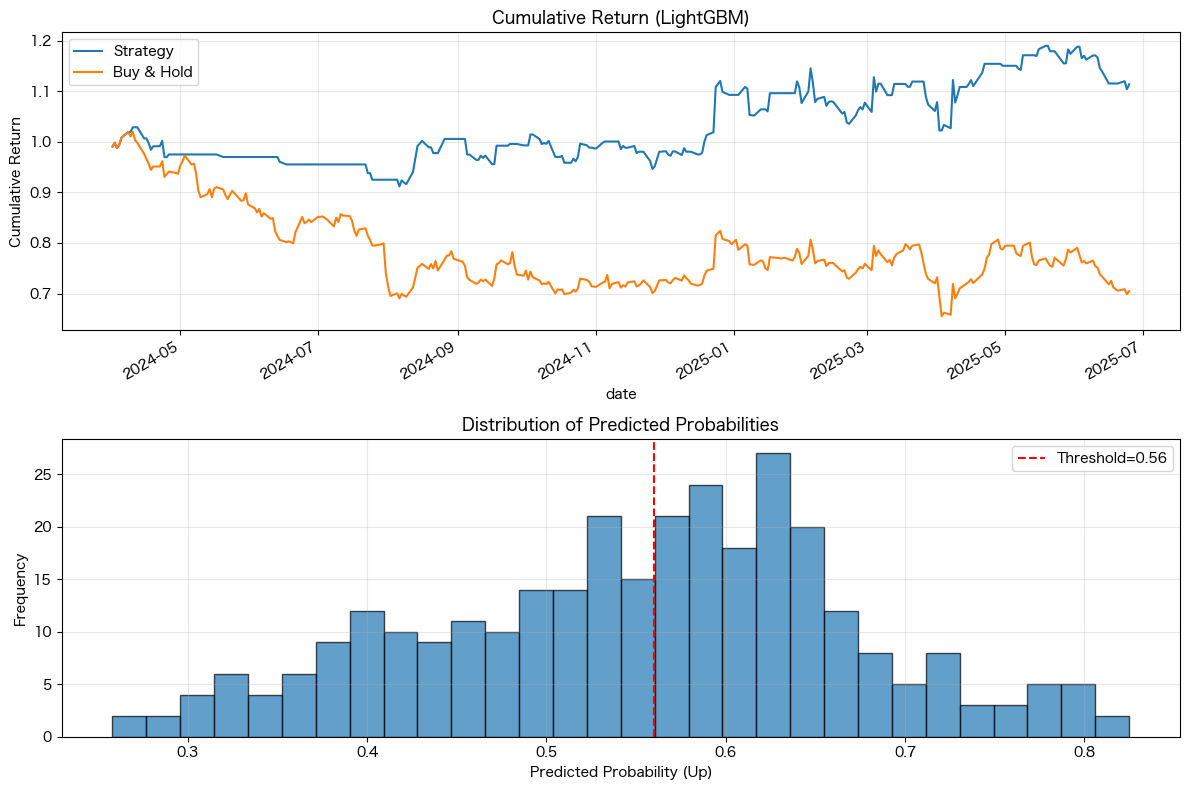

In [9]:
# 使用するテストデータの決定（LSTMの場合はシーケンス用にフィルタ）
if model_type == 'LSTM':
    results = test_filtered.copy()
else:
    results = test.copy()

results['prob_buy'] = y_prob
results['pred_buy'] = y_pred

# 予測したポジション(pred_buy)で、翌日のリターン(future_ret)を獲得
results['strategy_ret'] = results['pred_buy'] * results['future_ret']
results['buy_hold_ret'] = results['future_ret']

results['strategy_curve'] = (1 + results['strategy_ret']).cumprod()
results['buy_hold_curve'] = (1 + results['buy_hold_ret']).cumprod()

print(f'=== バックテスト結果（{model_type}モデル） ===')
print(f'戦略の最終倍率     : {results["strategy_curve"].iloc[-1]:.4f}')
print(f'買い持ち最終倍率   : {results["buy_hold_curve"].iloc[-1]:.4f}')
print(f'超過リターン       : {(results["strategy_curve"].iloc[-1] - results["buy_hold_curve"].iloc[-1]):.4f}')

# 取引統計
print(f'\n=== 取引統計 ===')
n_trades = results['pred_buy'].sum()
print(f'総取引回数         : {n_trades}')
if n_trades > 0:
    winning_trades = (results['strategy_ret'] > 0).sum()
    print(f'勝率               : {(winning_trades / n_trades * 100):.1f}%')
    print(f'平均リターン       : {results["strategy_ret"].mean():.4f}')
    print(f'最大リターン       : {results["strategy_ret"].max():.4f}')
    print(f'最小リターン       : {results["strategy_ret"].min():.4f}')
else:
    print('取引なし')

# プロット（クロスプラットフォーム対応フォント設定）
import matplotlib.pyplot as plt
import matplotlib
import platform

# クロスプラットフォーム対応のフォント設定
if platform.system() == 'Darwin':  # macOS
    matplotlib.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Maru Gothic Pro', 'Arial Unicode MS', 'DejaVu Sans']
elif platform.system() == 'Linux':
    matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'Noto Sans', 'DejaVu Sans']
else:  # Windows
    matplotlib.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 累積リターン
results[['strategy_curve', 'buy_hold_curve']].plot(ax=axes[0], title=f'Cumulative Return ({model_type})')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend(['Strategy', 'Buy & Hold'])
axes[0].grid(True, alpha=0.3)

# 予測確率の分布
axes[1].hist(results['prob_buy'], bins=30, alpha=0.7, edgecolor='black')
axes[1].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold:.2f}')
axes[1].set_xlabel('Predicted Probability (Up)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Probabilities')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 発表資料用グラフ

OS: Darwin
使用フォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


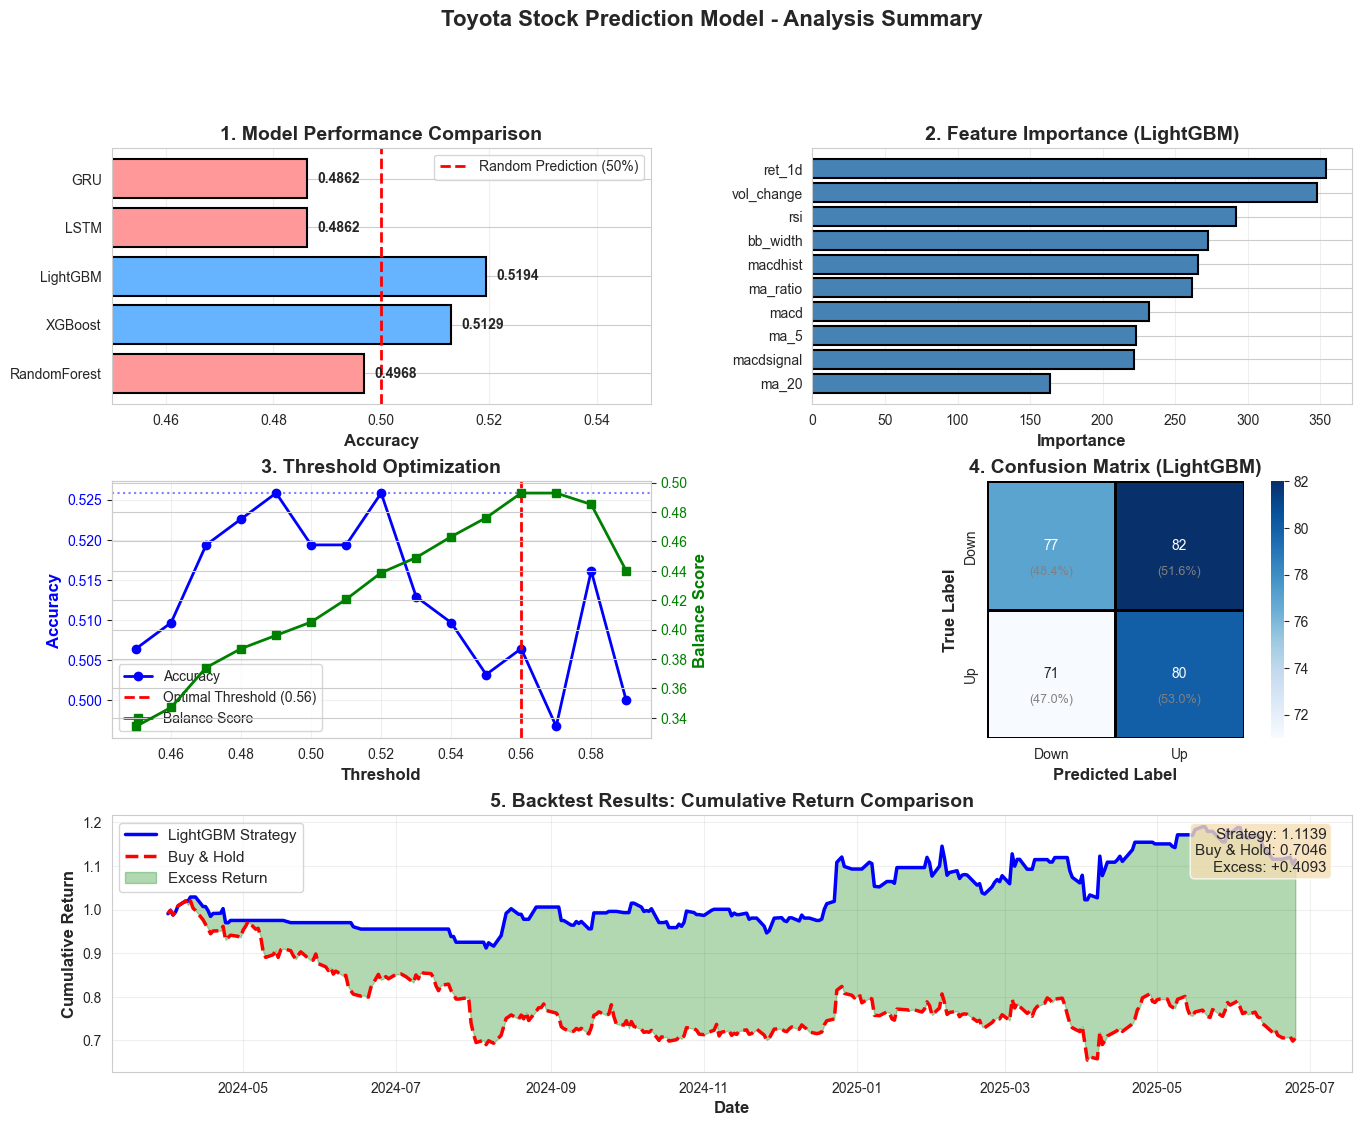

グラフ1完了：総合分析（5つのサブプロット）


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import platform

# クロスプラットフォーム対応のフォント設定
if platform.system() == 'Darwin':  # macOS
    matplotlib.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Maru Gothic Pro', 'Arial Unicode MS', 'DejaVu Sans']
elif platform.system() == 'Linux':
    matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'Noto Sans', 'DejaVu Sans']
else:  # Windows
    matplotlib.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10

print(f'OS: {platform.system()}')
print(f'使用フォント: {matplotlib.rcParams["font.sans-serif"]}')

# グラフ1: 総合分析（5つのサブプロット）
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. モデル比較
ax1 = fig.add_subplot(gs[0, 0])
models = ['RandomForest', 'XGBoost', 'LightGBM', 'LSTM', 'GRU']
accuracies = [rf_acc, xgb_acc, lgb_acc, lstm_acc, gru_acc]
colors = ['#ff9999' if acc < 0.50 else '#66b3ff' if acc < 0.52 else '#99ff99' for acc in accuracies]

bars = ax1.barh(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Random Prediction (50%)')
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('1. Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim(0.45, 0.55)
for i, (model, acc) in enumerate(zip(models, accuracies)):
    ax1.text(acc + 0.002, i, f'{acc:.4f}', va='center', fontsize=10, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. 特徴量重要度
ax2 = fig.add_subplot(gs[0, 1])
importance_data = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=True)

bars = ax2.barh(importance_data['feature'], importance_data['importance'], 
                color='steelblue', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('2. Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. 閾値と正解率
ax3 = fig.add_subplot(gs[1, 0])
thresholds = results_df['threshold'].values
accuracies_thresh = results_df['accuracy'].values
balance_scores = results_df['score'].values

ax3_twin = ax3.twinx()
line1 = ax3.plot(thresholds, accuracies_thresh, 'o-', color='blue', linewidth=2, 
                 markersize=6, label='Accuracy')
line2 = ax3_twin.plot(thresholds, balance_scores, 's-', color='green', linewidth=2, 
                      markersize=6, label='Balance Score')

ax3.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
ax3.axhline(best_accuracy, color='blue', linestyle=':', alpha=0.5)

ax3.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold', color='blue')
ax3_twin.set_ylabel('Balance Score', fontsize=12, fontweight='bold', color='green')
ax3.set_title('3. Threshold Optimization', fontsize=14, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='blue')
ax3_twin.tick_params(axis='y', labelcolor='green')
ax3.grid(alpha=0.3)

lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

# 4. 混同行列
ax4 = fig.add_subplot(gs[1, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'],
            ax=ax4, linewidths=2, linecolor='black', square=True)
ax4.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax4.set_title('4. Confusion Matrix (LightGBM)', fontsize=14, fontweight='bold')

for i in range(2):
    for j in range(2):
        percentage = cm_normalized[i, j] * 100
        ax4.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

# 5. 累積リターン
ax5 = fig.add_subplot(gs[2, :])
results_plot = test.copy()
results_plot['prob_buy'] = y_prob
results_plot['pred_buy'] = y_pred
results_plot['strategy_ret'] = results_plot['pred_buy'] * results_plot['future_ret']
results_plot['buy_hold_ret'] = results_plot['future_ret']
results_plot['strategy_curve'] = (1 + results_plot['strategy_ret']).cumprod()
results_plot['buy_hold_curve'] = (1 + results_plot['buy_hold_ret']).cumprod()

ax5.plot(results_plot.index, results_plot['strategy_curve'], 
         linewidth=2.5, label=f'{model_type} Strategy', color='blue')
ax5.plot(results_plot.index, results_plot['buy_hold_curve'], 
         linewidth=2.5, label='Buy & Hold', color='red', linestyle='--')
ax5.fill_between(results_plot.index, results_plot['strategy_curve'], 
                 results_plot['buy_hold_curve'], 
                 where=(results_plot['strategy_curve'] >= results_plot['buy_hold_curve']),
                 alpha=0.3, color='green', label='Excess Return')
ax5.fill_between(results_plot.index, results_plot['strategy_curve'], 
                 results_plot['buy_hold_curve'], 
                 where=(results_plot['strategy_curve'] < results_plot['buy_hold_curve']),
                 alpha=0.3, color='red')

ax5.set_xlabel('Date', fontsize=12, fontweight='bold')
ax5.set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
ax5.set_title('5. Backtest Results: Cumulative Return Comparison', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left', fontsize=11)
ax5.grid(alpha=0.3)

final_strategy = results_plot['strategy_curve'].iloc[-1]
final_buyhold = results_plot['buy_hold_curve'].iloc[-1]
excess = final_strategy - final_buyhold

ax5.text(0.98, 0.95, 
         f'Strategy: {final_strategy:.4f}\nBuy & Hold: {final_buyhold:.4f}\nExcess: {excess:+.4f}',
         transform=ax5.transAxes, fontsize=11, verticalalignment='top',
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Toyota Stock Prediction Model - Analysis Summary', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('グラフ1完了：総合分析（5つのサブプロット）')

In [11]:
# matplotlibフォントキャッシュをクリア（初回のみ実行）
import matplotlib.font_manager as fm
fm._load_fontmanager(try_read_cache=False)
print('フォントキャッシュをクリアしました')

Matplotlib is building the font cache; this may take a moment.


フォントキャッシュをクリアしました
